# Configuración spark

In [ ]:
# Instala Java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# Descargar Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar -xvzf spark-3.5.0-bin-hadoop3.tgz

spark-3.5.0-bin-hadoop3/
spark-3.5.0-bin-hadoop3/kubernetes/
spark-3.5.0-bin-hadoop3/kubernetes/tests/
spark-3.5.0-bin-hadoop3/kubernetes/tests/pyfiles.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/decommissioning.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/autoscale.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/python_executable_check.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/worker_memory_check.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/py_container_checks.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/decommissioning_cleanup.py
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/decom.sh
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/bindings/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/bindings/R/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/bindings/R/Dockerfile
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/bindings/python/
spark-3.5.0-bin-hadoop3/kubern

In [ ]:
# Instala findspark (facilita la integración con notebooks)
!pip install -q findspark

In [ ]:
# Variables de entorno:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
path_datos = "/content/drive/MyDrive/TFM/datos"

# Librerias

In [ ]:
import numpy as np
import pandas as pd
import pyspark.sql.functions as F

# from sklearn.preprocessing import RobustScaler
from sklearn.utils import class_weight

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import Recall, Precision

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Lectura de datos

In [ ]:
nombre_data_input = "datos_financieros_amzn_cleaned_19_25"

In [ ]:
datos_financieros = spark.read.parquet(f"{path_datos}/{nombre_data_input}")

In [ ]:
df_financiero = datos_financieros.toPandas().sort_values("date").reset_index(drop=True)

In [ ]:
len(df_financiero)

1510

In [ ]:
datos_financieros.groupBy("target").count().withColumn("pct", F.col("count") / datos_financieros.count()).show()

+------+-----+------------------+
|target|count|               pct|
+------+-----+------------------+
|     1|  505|0.3344370860927152|
|     0| 1005|0.6655629139072847|
+------+-----+------------------+



# Tratamiento

In [ ]:
# Identificamos las variables input
vars_input = [var for var in df_financiero.columns if var not in ["date","target"]]

In [ ]:
# Parámetros:
w_size = 20

In [ ]:
# Escalamos las variables input teniendo en cuenta únicamente los datos pasados
# Usamos la técnica rolling min-max
df_financiero_trat = df_financiero.copy()
for var in vars_input:
  v_unique = {"day_of_week": 7, "month": 12, "week_of_year": 53, "day_of_month": 31}
  vars_binarias = ["cross_ma_10d_vs_20d", "cross_ma_20d_vs_50d", "cross_ma_50d_vs_100d", "cross_ma_100d_vs_200d"]

  if var in v_unique:
    # Escalado de variables cíclicas:
    df_financiero_trat[f"{var}_sin"] = np.sin(2 * np.pi * df_financiero_trat[var]/v_unique[var])
    df_financiero_trat[f"{var}_cos"] = np.cos(2 * np.pi * df_financiero_trat[var]/v_unique[var])
    df_financiero_trat = df_financiero_trat.drop(var, axis=1)
  elif var not in vars_binarias:
    # Aplicamos un RobustScaler:
    median_w = df_financiero_trat[var].rolling(w_size).median()
    p75_w = df_financiero_trat[var].rolling(w_size).quantile(0.75)
    p25_w = df_financiero_trat[var].rolling(w_size).quantile(0.25)
    iqr_w = p75_w - p25_w
    df_financiero_trat[var] = (df_financiero_trat[var] - median_w) / iqr_w

    # # Aplicamos Z-Score
    # media_w = df_financiero_trat[var].shift(1).rolling(w_size).mean()
    # std_w = df_financiero_trat[var].shift(1).rolling(w_size).std()

    # std_w[std_w == 0] = 1 # Para evitar la division por 0
    # df_financiero_trat[var] = (df_financiero_trat[var] - media_w) / std_w

# Como los primeros 60 registros no tendrán suficientes datos, los eliminamos:
df_financiero_trat = df_financiero_trat.iloc[w_size:].reset_index(drop = True)

In [ ]:
print(df_financiero_trat.isna().sum().sum())

0


In [ ]:
vars_input_trat = [var for var in df_financiero_trat.columns if var not in ["date","target"]]

In [ ]:
# Primero separamos en train y test:
# Para evitar leakage temporal, debemos revisar que no incluyamos datos del test en en el entrenamiento
# Además, debemos asegurar el orden temporal:
train_size = int(0.8 * len(df_financiero_trat))
X = []
y = []

# 1- Calculamos las ventanas temporales
for i in range(w_size, len(df_financiero_trat)):
    X.append(df_financiero_trat.iloc[i - w_size:i, :][vars_input_trat].values)
    y.append(df_financiero_trat.iloc[i]['target'])

X = np.array(X)
y = np.array(y)

# 2- Separamos en train y test
X_train, X_test = X[:train_size - w_size], X[train_size - w_size:]
y_train, y_test = y[:train_size - w_size], y[train_size - w_size:]

In [ ]:
X_train.shape

(1172, 20, 68)

In [ ]:
X_test.shape

(298, 20, 68)

In [ ]:
len(df_financiero_trat)

1490

In [ ]:
X.shape

(1470, 20, 68)

In [ ]:
# Revisamos el escalado:
np.max(X_train), np.min(X_train)

(np.float64(283.6808467964895), np.float64(-31.311332838940313))

# Entrenamiento

In [ ]:
def lstm_model(input_shape):
  model = Sequential([Input(shape=input_shape),
                      LSTM(64, return_sequences=True),
                      Dropout(0.3),
                      LSTM(32),
                      Dense(64, activation='relu'),
                      Dropout(0.3),
                      Dense(1, activation='sigmoid')])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall(), Precision(), 'AUC'])
  return model

In [ ]:
# def lstm_model(input_shape):
#   model = Sequential([Input(shape=input_shape),
#                       LSTM(64, return_sequences=False),
#                       Dropout(0.3),
#                       Dense(32, activation='relu'),
#                       Dropout(0.3),
#                       Dense(1, activation='sigmoid')])
#   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall(), Precision(), 'AUC'])
#   return model

In [ ]:
n_cols = len(vars_input_trat)

base_model = lstm_model(input_shape=(w_size, n_cols))
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,641 (190.00 KB)

 Trainable params: 48,641 (190.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Aplicamos peso a las clases para balancear:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

class_weights = dict(enumerate(class_weights))

In [ ]:
early_stop_param = EarlyStopping(patience=5, restore_best_weights=True, monitor = "val_loss")

model_history = base_model.fit(X_train, y_train,
                               validation_split = 0.2,
                               epochs=50,
                               batch_size=32,
                               callbacks=[early_stop_param],
                               verbose = 1,
                               class_weight=class_weights)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - AUC: 0.5225 - loss: 0.6915 - precision: 0.3560 - recall: 0.1820 - val_AUC: 0.5473 - val_loss: 0.6747 - val_precision: 0.4000 - val_recall: 0.3571
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 0.7243 - loss: 0.6387 - precision: 0.5019 - recall: 0.6267 - val_AUC: 0.5293 - val_loss: 0.6689 - val_precision: 0.4259 - val_recall: 0.2738
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - AUC: 0.7915 - loss: 0.5695 - precision: 0.6181 - recall: 0.6376 - val_AUC: 0.5240 - val_loss: 0.6841 - val_precision: 0.5208 - val_recall: 0.2976
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - AUC: 0.8423 - loss: 0.5147 - precision: 0.5951 - recall: 0.7727 - val_AUC: 0.5716 - val_loss: 0.7121 - val_precision: 0.4268 - val_recall: 0.4167
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - AUC: 0.8625 - loss: 0.4787 - precision: 0.6090 - recall: 0.8428 - val_AUC: 0.5412 - val_loss: 0.7328 - val_precision: 0.4333 - val_recall: 0.3095
Epoc

## Evaluación del modelo

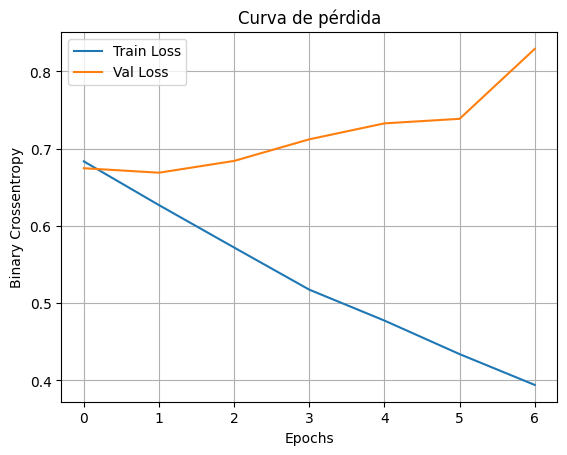

In [ ]:
plt.plot(model_history.history['loss'], label='Train Loss')
plt.plot(model_history.history['val_loss'], label='Val Loss')
plt.title("Curva de pérdida")
plt.xlabel("Epochs")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
base_model.evaluate(X_test, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.5739 - loss: 0.6732 - precision: 0.5135 - recall: 0.3949


[0.678198516368866,
 0.40909090638160706,
 0.4326923191547394,
 0.5688346028327942]

In [ ]:
loss_resultado, recall_resultado, prec_resultado, auc_resultado = base_model.evaluate(X_test, y_test)
print(f"Test Recall: {recall_resultado:.4f}")
print(f"Test Precision: {prec_resultado:.4f}")
print(f"Test AUC: {auc_resultado:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.5739 - loss: 0.6732 - precision: 0.5135 - recall: 0.3949
Test Recall: 0.4091
Test Precision: 0.4327
Test AUC: 0.5688


In [ ]:
y_pred_prob = base_model.predict(X_test)
y_pred = (y_pred_prob > 0.45).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
[[116  72]
 [ 48  62]]
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       188
           1       0.46      0.56      0.51       110

    accuracy                           0.60       298
   macro avg       0.59      0.59      0.58       298
weighted avg       0.62      0.60      0.60       298

AUC: 0.5692456479690522


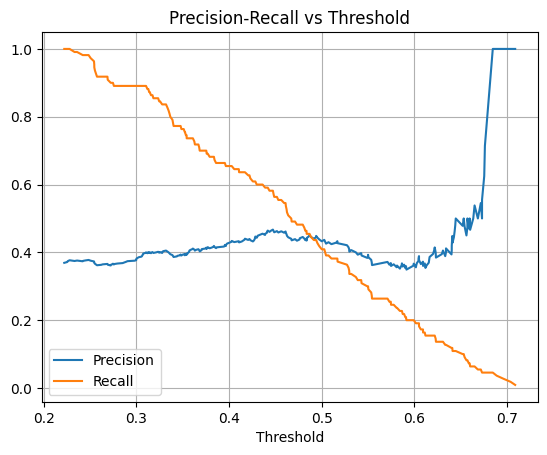

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.title('Precision-Recall vs Threshold')
plt.grid(True)
plt.show()